In [21]:
import pandas as pd

# Load the metadata
metadata = pd.read_csv('HAM10000_metadata.csv')

# Display the first few rows of the dataframe
print(metadata.head())

# Check for missing values
print(metadata.isnull().sum())

# Display data types of each column
print(metadata.dtypes)


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object


Unique values in 'dx': ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


C:\Users\Pc\AppData\Local\Temp\ipykernel_16664\2785688168.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=metadata['dx'], order=metadata['dx'].value_counts().index, palette="viridis")


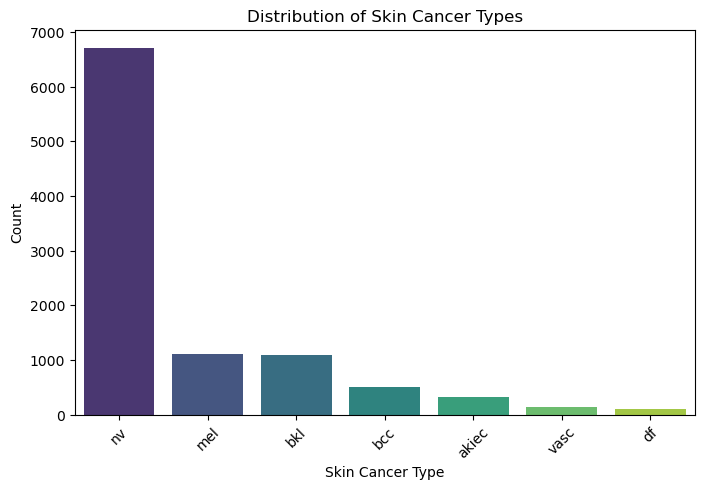

In [22]:
# Check unique values in the 'dx' column
print("Unique values in 'dx':", metadata['dx'].unique())

# Count the number of occurrences for each class
print("\nClass distribution:")
print(metadata['dx'].value_counts())

# Visualize class distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x=metadata['dx'], order=metadata['dx'].value_counts().index, palette="viridis")
plt.title("Distribution of Skin Cancer Types")
plt.xlabel("Skin Cancer Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()




In [23]:
# Display data types again
print(metadata.dtypes)

# Convert 'age' column to integer (if it's not already)
# metadata['age'] = metadata['age'].astype('int')

# Convert categorical columns to category type
categorical_columns = ['dx', 'sex', 'localization']
for col in categorical_columns:
    metadata[col] = metadata[col].astype('category')

# Verify the changes
print(metadata.dtypes)


lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object
lesion_id         object
image_id          object
dx              category
dx_type           object
age              float64
sex             category
localization    category
dtype: object


In [24]:
# Check for missing values again
print(metadata.isnull().sum())

# Fill missing values in 'age' with the median value
metadata['age'].fillna(metadata['age'].median(), inplace=True)

# If other columns have missing values, we can either drop them or fill them
metadata.dropna(inplace=True)  # This removes rows with missing values


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


C:\Users\Pc\AppData\Local\Temp\ipykernel_16664\2526175247.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age'].fillna(metadata['age'].median(), inplace=True)


In [25]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'dx' column (target variable)
encoder = LabelEncoder()
metadata['dx_encoded'] = encoder.fit_transform(metadata['dx'])

# Display the mapping of labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping:", label_mapping)

# Show first few rows to check encoding
print(metadata[['dx', 'dx_encoded']].head())


Label Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
    dx  dx_encoded
0  bkl           2
1  bkl           2
2  bkl           2
3  bkl           2
4  bkl           2


In [ ]:
import os

# Define paths to image folders
image_folder_1 = "HAM10000_images_part_1"
image_folder_2 = "HAM10000_images_part_2"

# Combine both folders into a single list of available images
all_image_files = os.listdir(image_folder_1) + os.listdir(image_folder_2)

# Check how many images are available
print("Total images found:", len(all_image_files))


Total images found: 10015


In [28]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to find the correct image path
def get_image_path(image_id):
    if image_id + ".jpg" in os.listdir(image_folder_1):
        return os.path.join(image_folder_1, image_id + ".jpg")
    elif image_id + ".jpg" in os.listdir(image_folder_2):
        return os.path.join(image_folder_2, image_id + ".jpg")
    else:
        return None  # Image not found

# Add a new column to metadata with image paths
metadata["image_path"] = metadata["image_id"].apply(get_image_path)

# Drop rows where image is not found
metadata = metadata.dropna(subset=["image_path"])

# Show first few rows to check
print(metadata[["image_id", "image_path"]].head())


       image_id                               image_path
0  ISIC_0027419  HAM10000_images_part_1\ISIC_0027419.jpg
1  ISIC_0025030  HAM10000_images_part_1\ISIC_0025030.jpg
2  ISIC_0026769  HAM10000_images_part_1\ISIC_0026769.jpg
3  ISIC_0025661  HAM10000_images_part_1\ISIC_0025661.jpg
4  ISIC_0031633  HAM10000_images_part_2\ISIC_0031633.jpg


In [9]:
image_size = (100, 100)  # Resize images to 100x100

# Function to load and process images
def load_image(image_path):
    img = load_img(image_path, target_size=image_size)  # Load image
    img_array = img_to_array(img) / 255.0  # Convert to array & normalize
    return img_array

# Apply function to all image paths
metadata["image_array"] = metadata["image_path"].apply(load_image)

# Convert list of image arrays into a NumPy array
X_images = np.array(metadata["image_array"].tolist())

# Convert target labels to NumPy array
y_labels = metadata["dx_encoded"].values

print("Shape of image data:", X_images.shape)
print("Shape of labels:", y_labels.shape)


Shape of image data: (10015, 100, 100, 3)
Shape of labels: (10015,)


In [10]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Check the shapes of the sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (8012, 100, 100, 3) (8012,)
Testing set shape: (2003, 100, 100, 3) (2003,)


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [32]:
# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    
    # Second convolutional layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolutional layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the layers
    Flatten(),

    # Fully connected (dense) layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting

    # Output layer (number of classes = unique labels in 'dx_encoded')
    Dense(len(set(y_labels)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()


c:\Users\Pc\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,679 (6.61 MB)

 Trainable params: 1,732,679 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),  
    epochs=30,  
    batch_size=32
)


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.6566 - loss: 1.1226 - val_accuracy: 0.6695 - val_loss: 0.9330
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6770 - loss: 0.9462 - val_accuracy: 0.6685 - val_loss: 0.9235
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.6657 - loss: 0.9217 - val_accuracy: 0.6965 - val_loss: 0.8203
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6755 - loss: 0.8654 - val_accuracy: 0.6705 - val_loss: 0.8268
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.6898 - loss: 0.8292 - val_accuracy: 0.6855 - val_loss: 0.8117
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.6971 - loss: 0.8142 - val_accuracy: 0.7069 - val_loss: 0.7745
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.7066 - loss: 0.7721 - val_accuracy: 0.7109 - val_loss: 0.7730
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.7167 - loss: 0.7407 - 

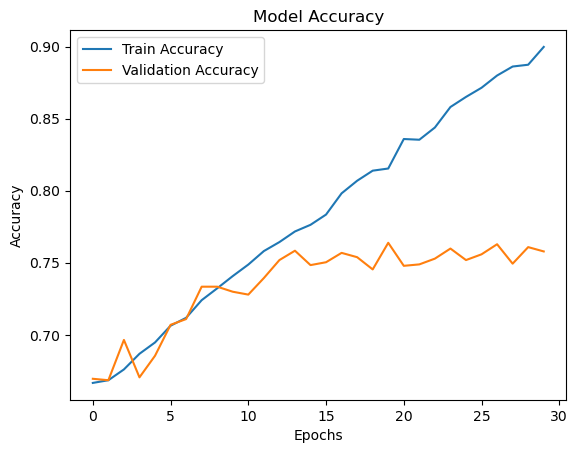

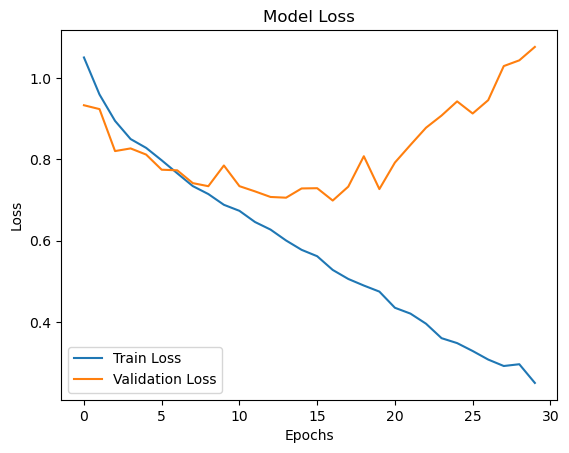

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [35]:
# Save the trained model
model.save("skin_cancer_model.h5")

print("Model saved successfully!")


Model saved successfully!


In [40]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("skin_cancer_model.h5")

# Test on a random image from the test set
import numpy as np

random_index = np.random.randint(0, len(X_test))  # Pick a random test image
test_image = np.expand_dims(X_test[random_index], axis=0)  # Add batch dimension

# Get prediction
prediction = loaded_model.predict(test_image)
predicted_class = np.argmax(prediction)  # Get class with highest probability

# Map predicted class to original labels
label_mapping_inverse = {v: k for k, v in label_mapping.items()}
predicted_label = label_mapping_inverse[predicted_class]

print("Predicted Class:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Class: nv
